# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 concepts.

* Using [chat messages](https://docs.langchain.com/oss/python/langchain/messages) as our graph state
* Using [chat models](https://docs.langchain.com/oss/python/integrations/chat) in graph nodes
* [Binding tools](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to our chat model
* [Executing tool calls](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

## Messages

Chat models can use [messages](https://docs.langchain.com/oss/python/langchain/messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Pytholic"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Pytholic"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Pytholic

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Pytholic

I want to learn about the best place to see Orcas in the US.


## Chat Models

Chat models use a sequence of messages as input and support message types, as discussed above.

There are [many](https://docs.langchain.com/oss/python/integrations/chat) to choose from! Let's work with OpenAI. 

Let's check that your `GOOGLE_API_KEY` is set and, if not, you will be asked to enter it.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
result

AIMessage(content='That\'s a fantastic question! When it comes to seeing Orcas in the US, there are two primary contenders for the "best" place, each offering a slightly different experience:\n\n1.  **The San Juan Islands, Washington (Salish Sea):**\n    *   **Why it\'s often considered the #1 spot:** This area, encompassing the waters around Friday Harbor, San Juan Island, and the broader Puget Sound/Salish Sea, is historically famous for its **Southern Resident Killer Whales** (J, K, and L Pods). These are fish-eating Orcas that traditionally spend significant time here during the summer months, feeding on Chinook salmon.\n    *   **Current Situation:** While the Southern Residents are endangered and their numbers are low, making *their* sightings less frequent and reliable than in the past, the good news is that **Bigg\'s (transient) Killer Whales** are increasingly common and reliable in the Salish Sea. These are mammal-eating Orcas that hunt seals, sea lions, and porpoises, and th

In [11]:
result.usage_metadata | result.response_metadata

{'input_tokens': 46,
 'output_tokens': 1935,
 'total_tokens': 1981,
 'input_token_details': {'cache_read': 0},
 'output_token_details': {'reasoning': 1069},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash',
 'safety_ratings': [],
 'model_provider': 'google_genai'}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://docs.langchain.com/oss/python/integrations/chat) and [tool calling interface](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [12]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [13]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="pytholic")])

In [15]:
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (5054854d-5dc2-46c9-b2b1-ac5f660d9e29)
 Call ID: 5054854d-5dc2-46c9-b2b1-ac5f660d9e29
  Args:
    b: 3
    a: 2


In [14]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'b': 3, 'a': 2},
  'id': '5054854d-5dc2-46c9-b2b1-ac5f660d9e29',
  'type': 'tool_call'}]

The above syntax is different from langchain where we use `@tool` decorator to define the tool and then pass it to `create_agent` function.

```python
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

multiply_tool = multiply.bind_tools()

model = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", temperature=0.0)

agent = create_agent(
    model=model,
    tools=[tool1],
    system_prompt="You are an arithmetic wizard. Use your tools to calculate the square root and square of any number."
)

question = HumanMessage(content="What is 2 multiplied by 3")

response = agent.invoke(
    {"messages": [question]}
)

print(response['messages'][-1].content)
```

## Using messages as state

With these foundations in place, we can now use  [messages](https://docs.langchain.com/oss/python/langchain/overview#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [16]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will overwrite the prior `messages` value!
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers) to address this.

Reducers specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [17]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built  [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [20]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [19]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='00249ae7-b903-45e9-85f3-ef6ab1479bc0', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='0b2cde00-f499-4552-82f0-e4d8e907630c'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='c4afff09-1245-4cf1-8346-7ea78614c194', tool_calls=[], invalid_tool_calls=[])]

## Our graph

Now, lets use `MessagesState` with a graph.

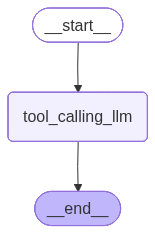

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass
 
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! I am a large language model, able to perform various tasks. What can I do for you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (5f0aa741-506a-4edb-a19a-d06e4395c5e2)
 Call ID: 5f0aa741-506a-4edb-a19a-d06e4395c5e2
  Args:
    a: 2
    b: 3
